## ANN, Flax, Optax

So far, you've seen how to define a model using jax, train the model, do backpropagation, and test it. Let's take it a bit further. In this notebook we'll be writing a simple ANN to classify penguin species using the [palmers penguin dataset](https://github.com/mcnakhaee/palmerpenguins).

Since it's the first notebook on something NN, it'll be a good opportunity to introduce the Neural Net library in the Jax ecosystem, Flax. Also, like the linear regression example, we'll have to update the model parameters during backpropagation, for which there is also a library, Optax. In this notebook, I'll show you how to use both with a simple classifier.

Let's load the data and process it to get started. (apparently the main focus of this notebook is to show you the ANN and not how you can load data, so, I'm going to short circuit the data related process a bit)

### Data

In [1]:
import numpy as np
import pandas as pd
from palmerpenguins import load_penguins

In [2]:
import jax
import jax.numpy as jnp

from tqdm.auto import tqdm
from sklearn import preprocessing


def load_data():
    penguins = load_penguins() # penguins is a dataframe
    penguins = penguins.dropna() # type: ignore
    
    # print the head of the dataframe to give some view
    print(penguins.head()) # type: ignore
    
    # collect the feature columns
    feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
    # classification target
    target_column = "species"
    
    # features and targets
    features = penguins[feature_columns].values  # type: ignore
    targets = penguins[target_column].values  # type: ignore
    
    # but here's a catch
    # the targets are categorical, so we have two two options here
    # one hot encode them, or, assign a numeric value to them and keep a dictionary
    # with the target label to int mapping
    # the second approach is easier xD
    
    target_ids_dict = dict()
    unique_target_labels = set(targets)
    _id = 0
    
    for ul in unique_target_labels:
        target_ids_dict[ul] = _id
        _id += 1
        
    # convert target labels to integers using the same dict
    def convert_label_to_ids(targets, id_dict):
        converted_targets = np.zeros(shape=(len(targets, )), dtype=np.int32)
        for idx, target in tqdm(enumerate(targets)):
            converted_targets[idx] = id_dict[target]

        return converted_targets
    
    targets_converted = convert_label_to_ids(
        targets=targets, id_dict=target_ids_dict)
    
    assert features.shape[0] == targets_converted.shape[0]
    
    # the features from the dataset are not normalised and
    # this can cause probblems during training, such as 
    # gradients getting stuck in a local minima
    # there's a lot of literature which talks about the 
    # necessity of normalisation, this is a good starter
    # https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
    
    features_norm = preprocessing.normalize(features, norm="l2")
    
    
    return (features_norm, targets_converted)
    
    
X, y = load_data()
print(X.shape) # type: ignore
print(y.shape) # type: ignore

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
4       3450.0  female  2007  
5       3650.0    male  2007  


0it [00:00, ?it/s]

(333, 4)
(333,)


Okay splendid. Now to create the data split and also convert these numpy arrays to jax arrays. 

In [3]:
from sklearn.model_selection import train_test_split

features_train, features_test, targets_train, targets_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


features_train = jnp.array(features_train)
features_test = jnp.array(features_test)
targets_train = jnp.array(targets_train)
targets_test = jnp.array(targets_test)


print(f"Train Size : {features_train.shape[0]}")
print(f"Test Size: {features_test.shape[0]}")

Train Size : 233
Test Size: 100


### ANN

This is going to be a 2 layer ANN with ReLU activation, 3 target classes and cross entropy as the loss function.

#### PRNG

In [4]:
# old ritual of generating prngs
key = jax.random.PRNGKey(42)

#### ANN definition

In Flax, `flax.linen` provides all the necessary bells and whistles to implement neural networks. If you're coming from pytorch, this is equivalent to `torch.nn`.

Another intresting thing about Flax is that, despite Jax being functional, Flax does make use of classes (as PyTorch does!). Let's see the class definition. 

In [5]:
import flax.linen as nn


class PenguinFinder(nn.Module):
    in_dim: int
    hidden_dim: int
    out_dim: int
    
    def setup(self):        
        # layer definition goes here
        self.layer1 = nn.Dense(features=self.in_dim)
        self.hidden = nn.Dense(features=self.hidden_dim)
        self.layer2 = nn.Dense(features=self.out_dim)

    def __call__(self, x):
        out = self.layer1(x)
        # out = nn.relu(out)
        
        out = self.hidden(out)
        # out = nn.relu(out)
        
        out = self.layer2(out)
        out = nn.leaky_relu(out)

        # apply softmax to convert to 
        # probability distribution
        logits = jax.nn.softmax(out)

        return logits
    
    
# init model
model = PenguinFinder(in_dim=4, hidden_dim=4, out_dim=3)

# model params
# requires a PRNG key and an array with the same shape of unbatched input
params = model.init(key, features_train[0])

params


/home/kafka/miniconda3/envs/jax_examples/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


FrozenDict({
    params: {
        layer1: {
            kernel: Array([[-0.70834756,  0.19896099,  0.7694369 , -0.23189932],
                   [-0.47285444, -0.07184912,  0.8260922 ,  0.73942983],
                   [ 0.06956226,  0.09228842, -0.66941226,  0.18486018],
                   [-0.03664388, -0.503816  , -0.5839758 , -0.79000473]],      dtype=float32),
            bias: Array([0., 0., 0., 0.], dtype=float32),
        },
        hidden: {
            kernel: Array([[-0.6737278 , -0.19237037, -0.08780637,  0.01149246],
                   [-0.28743574,  0.7021017 ,  0.13110416, -0.68563247],
                   [-0.10748527, -0.71319515,  0.13990045, -0.14919583],
                   [-0.59424335, -0.50301826,  0.01179116, -0.20305212]],      dtype=float32),
            bias: Array([0., 0., 0., 0.], dtype=float32),
        },
        layer2: {
            kernel: Array([[-0.09222206,  0.4667406 ,  0.98243344],
                   [-0.2338884 , -0.5236663 ,  1.0447854 ],
         

In [6]:
# example forward pass
model.apply(params, features_train[0])

Array([0.1889907 , 0.16631629, 0.6446931 ], dtype=float32)

The `setup` method comes in handy if you have to modify the default behavior of some linen class or want to define your own custom layers. If this is not the case (you want to use linen classes as they are), you can reduce the code by getting rid of setup and using `compact`. The class definition will then look like this

```python
class PenguinFinder(nn.Module):
    in_dim: int
    hidden_dim: int
    out_dim: int

    @nn.compact
    def __call__(self, x):
        out = nn.Dense(features=self.in_dim)(x)
        out = nn.Dense(features=self.hidden_dim)(out)
        out = nn.Dense(features=self.out_dim)(out)
        out = nn.leaky_relu(out)
        
        # apply softmax
        logits = jax.nn.softmax(out)
        
        return logits
```

params from a linen module are returned as a Frozen dict, which is immutable. During training, when we won't be updating the params in place, rather Flax has some nifty trick with training state which we'll see pretty soon.

#### Loss function and grad

The formal definition of cross entropy loss for a multiclass classification is this: 
$$
ce = -\sum_{c=1}^My_{t}\log(p_{t})
$$

where, $t$ stands for the correct class

$y_t$ is the correct label and $p_t$ is what a model predicted for $t$

There is a nifty trick to it if you represent your classes with int ids as I have done above. The ids start from 0, so you can basically treat them as indexes. Using this, the cross entropy for an instance basically becomes

$$
ce = -ln(p_t)
$$

This trick works fine for single dimension multi class probabilities. I have never verified it outside course assignments or simple experiments. Then again, this notebook is just here to show you how jax works. In practice, it'll be buckwild to write everything from scratch. *Don't violate the DRY principle!*

In [7]:
# loss function
# for a single instance
# will vmap for batches

@jax.jit
def cross_entropy(params, x, y):
    # forward pass .....
    logits = model.apply(params, x)
    
    return -jnp.log(logits[y]) # type: ignore


cross_entropy(params, features_train[0], targets_train[0])


Array(1.6660575, dtype=float32)

In [8]:
@jax.jit
def calculate_loss(params, x_batched, y_batched):
    batch_loss = jax.vmap(cross_entropy, in_axes=(None, 0, 0))(params, x_batched, y_batched)
    return jnp.mean(batch_loss)


calculate_loss(params, features_train, targets_train)


Array(1.216441, dtype=float32)

#### Optimisation

This is where we introduce Optax. For this notebook, I'm using the Adam optimiser. 

There are other optimizers in Optax which you can use: https://optax.readthedocs.io/en/latest/api.html

Also, more on Adam: https://arxiv.org/abs/1412.6980


In [9]:
import optax

optimiser = optax.adam(learning_rate=0.01)
loss_grad_fn = jax.value_and_grad(calculate_loss)


#### Flax Train state

Okay so we've an optimiser but we need to tell it how it should be updating the parameters. We can do it only using optax, go through the frozen dict (after making it immutable and froze it agian) but that's too much hassle and opens up more avenues for user error. Instead we'll be using `train_state` in Flax.

In [10]:
from flax.training import train_state

model_state = train_state.TrainState.create(
    apply_fn=model.apply, # the forward function
    params=params,
    tx=optimiser
)

During training, all we have to do is update this model state, and Flax will do the rest for us. (It'll be easier to understand the whole process if we consider params as states for models.)

#### Train-ing
Finally! Der Zug ist da! (Oh wait..........no, it's late again.)

In [11]:
# batched
@jax.jit
def train_step(state, xs, ys):
    loss_value, grads = loss_grad_fn(state.params, xs, ys)
    state = state.apply_gradients(grads=grads)
    return loss_value, state
    

In [12]:
from tqdm.auto import trange


def train(state, xs, ys, epochs, log_every_n_step):
    losses = list() # keeps track of losses every n steps
    steps = list()

    step_count = 0

    for e in trange(epochs):
        loss, state = train_step(state, xs, ys)
        if step_count % log_every_n_step == 0:
            losses.append(loss)
            steps.append(step_count)
            
            print(f"Epoch = {e + 1} / {epochs} \t :: Train Loss = {loss}")
        step_count += 1

    return state, losses, steps


In [13]:
trained_model_state, losses, steps = train(model_state, features_train, targets_train, 2000, 50)

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch = 1 / 2000 	 :: Train Loss = 1.216441035270691
Epoch = 51 / 2000 	 :: Train Loss = 1.047715663909912
Epoch = 101 / 2000 	 :: Train Loss = 1.045149326324463
Epoch = 151 / 2000 	 :: Train Loss = 1.0398658514022827
Epoch = 201 / 2000 	 :: Train Loss = 1.021933674812317
Epoch = 251 / 2000 	 :: Train Loss = 0.9413605332374573
Epoch = 301 / 2000 	 :: Train Loss = 0.7373837232589722
Epoch = 351 / 2000 	 :: Train Loss = 0.6524370312690735
Epoch = 401 / 2000 	 :: Train Loss = 0.6227151155471802
Epoch = 451 / 2000 	 :: Train Loss = 0.6071419715881348
Epoch = 501 / 2000 	 :: Train Loss = 0.5936983823776245
Epoch = 551 / 2000 	 :: Train Loss = 0.5816537737846375
Epoch = 601 / 2000 	 :: Train Loss = 0.5673043727874756
Epoch = 651 / 2000 	 :: Train Loss = 0.5528332591056824
Epoch = 701 / 2000 	 :: Train Loss = 0.5371620655059814
Epoch = 751 / 2000 	 :: Train Loss = 0.52076256275177
Epoch = 801 / 2000 	 :: Train Loss = 0.503818154335022
Epoch = 851 / 2000 	 :: Train Loss = 0.4867570996284485
Ep

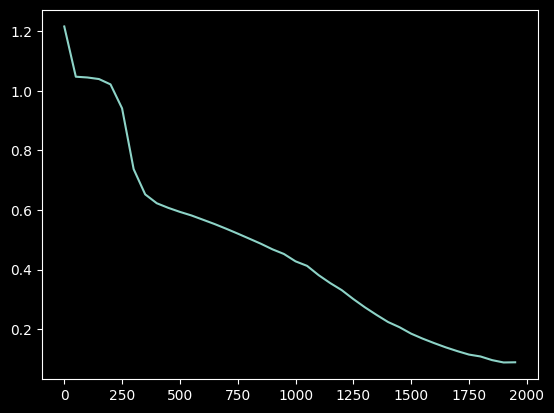

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


sns.lineplot(x=np.array(steps), y=np.array(losses))
plt.show()

### Evaluation

In [15]:
@jax.jit
def test_step(state, x):
    logits = model.apply(state.params, x)
    out = jnp.argmax(logits, axis=-1)
    
    return out


@jax.jit
def test(state, xs):
    return jax.vmap(test_step, in_axes=(None, 0))(state, xs)


In [16]:
predictions = test(trained_model_state, features_test)


In [17]:
from sklearn.metrics import classification_report

report = classification_report(y_pred=predictions, y_true=targets_test)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        48
           1       0.95      0.91      0.93        23
           2       1.00      1.00      1.00        29

    accuracy                           0.97       100
   macro avg       0.97      0.96      0.97       100
weighted avg       0.97      0.97      0.97       100

